# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from mls import plot_rosenbrock, plot_posterior

## Frameworks

In this notebook, we introduce on some useful frameworks for practical calculations, rather than describe any new techniques.  We consider two types of frameworks:
 - Frameworks to build and efficiently run a computational graph.
 - Frameworks for [probabilistic programming](https://en.wikipedia.org/wiki/Probabilistic_programming_language).
 
Note that a probabilistic programming framework often builds on a lower-level computational graph framework.

### Computation Graphs: Tensorflow

https://www.tensorflow.org/programmers_guide/low_level_intro#graph

In [3]:
import tensorflow as tf

In [4]:
print(tf.__version__)

1.5.0


#### Example: calculation with constants

Here is a simple calculation in python involving constants:

In [5]:
a = 1.0
b = 2.0
c = a + b
print(' a = {}\n b = {}\n c = {}'.format(a, b, c))

 a = 1.0
 b = 2.0
 c = 3.0


The tensorflow equivalent is more involved since it requires two stages. First, we build a graph, which captures the structure of the calculation but contains no values:

In [6]:
g1 = tf.Graph()
with g1.as_default():
    a = tf.constant(1.0, name='a')
    b = tf.constant(2.0, name='b')
    c = tf.add(a, b, name='c') # a + b also valid but is un-named.
print(' a = {}\n b = {}\n c = {}'.format(a, b, c))

 a = Tensor("a:0", shape=(), dtype=float32)
 b = Tensor("b:0", shape=(), dtype=float32)
 c = Tensor("c:0", shape=(), dtype=float32)


The `tensorboard` program allows graphs (and summary results) to be visualized in the browser:

In [7]:
tf.summary.FileWriter('tfs/intro1', graph=g1);

```
% tensorboard --logdir tfs/intro1
TensorBoard 1.5.1 at http://localhost:6006 (Press CTRL+C to quit)
```

![sum graph](img/Frameworks/sum_graph.png)

The second stage is to run the graph in a session:

In [8]:
with tf.Session(graph=g1) as s1:
    c_out = s1.run(c)
print(' c = {}'.format(c_out))

 c = 3.0


#### Example: calculation with variables

In [9]:
def rosenbrock(x):
    x0, x1 = x
    a, b = 1., 100.
    return (a - x0) ** 2 + b * (x1 - x0 ** 2) ** 2

In [10]:
print(rosenbrock([1., 1.]))
print(rosenbrock([0.5, -0.5]))

0.0
56.5


In [11]:
g2 = tf.Graph()
with g2.as_default():
    x = tf.placeholder(tf.float32, shape=(2,), name='x')
    x0 = tf.slice(x, [0], [1], name='x0')
    x1 = tf.slice(x, [1], [1], name='x1')
    a = tf.constant(1., name='a')
    b = tf.constant(100., name='b')
    with tf.name_scope('rosenbrock'):
        rosenbrock = (a - x0) ** 2 + b * (x1 - x0 ** 2) ** 2

In [12]:
tf.summary.FileWriter('tfs/intro2', graph=g2);

The new tensorboard graph is:
![rosenbrock graph](img/Frameworks/rosenbrock_graph.png)
Double clicking on the "rosenbrock" node reveals its internal structure, composed of primitive building blocks:
![rosenbrock graph](img/Frameworks/rosenbrock_graph2.png)

In [13]:
with tf.Session(graph=g2) as s2:
    print(s2.run(rosenbrock, feed_dict={x: [1., 1.]}))
    print(s2.run(rosenbrock, feed_dict={x: [0.5, -0.5]}))

[ 0.]
[ 56.5]


Add the line:
```
    rosenbrock_grad = tf.gradients(rosenbrock, [x])
```
to the example above to extend the graph to calculate the partial derivatives of the Rosenbrock function with respect to the components of `x`:

In [14]:
g3 = tf.Graph()
with g3.as_default():
    x = tf.placeholder(tf.float32, shape=(2,), name='x')
    x0 = tf.slice(x, [0], [1], name='x0')
    x1 = tf.slice(x, [1], [1], name='x1')
    a = tf.constant(1., name='a')
    b = tf.constant(100., name='b')
    with tf.name_scope('rosenbrock'):
        rosenbrock = (a - x0) ** 2 + b * (x1 - x0 ** 2) ** 2
    rosenbrock_grad = tf.gradients(rosenbrock, [x])

In [15]:
tf.summary.FileWriter('tfs/intro3', graph=g3);

In [16]:
with tf.Session(graph=g3) as s3:
    print(s3.run(rosenbrock_grad, feed_dict={x: [1., 1.]}))
    print(s3.run(rosenbrock_grad, feed_dict={x: [0.5, -0.5]}))

[array([ 0.,  0.], dtype=float32)]
[array([ 149., -150.], dtype=float32)]


#### Example: optimization

Add the lines:
```
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05, name='optimizer')
    step = optimizer.minimize(rosenbrock, name='step')
```
to extend the graph to perform optimization, i.e., to iteratively update `x` to move towards a (local) minimum. We We also need to change `x` from a `placeholder` to a `Variable` since it is now being updated internally:

In [17]:
g4 = tf.Graph()
with g4.as_default():
    x = tf.Variable([-1., 0.], name='x')
    x0 = tf.slice(x, [0], [1], name='x0')
    x1 = tf.slice(x, [1], [1], name='x1')
    a = tf.constant(1., name='a')
    b = tf.constant(100., name='b')
    with tf.name_scope('rosenbrock'):
        rosenbrock = (a - x0) ** 2 + b * (x1 - x0 ** 2) ** 2
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05, name='optimizer')
    step = optimizer.minimize(rosenbrock, name='step')
    initialize = tf.global_variables_initializer()

The graph knows what variables it can be optimized (trained) over:

In [18]:
g4.get_collection('trainable_variables')

[<tf.Variable 'x:0' shape=(2,) dtype=float32_ref>]

Run the optimizer in a session and save its path. You can also [save summary data](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard#serializing_the_data) to the log file for later inspection in tensorboard.

In [19]:
with tf.Session(graph=g4) as s4:
    s4.run(initialize)
    path = [s4.run(x)]
    for i in range(2000):
        s4.run(step)
        path.append(s4.run(x))

Note that the [Adam optimizer](https://arxiv.org/abs/1412.6980) is relatively new (2014) and not yet implemented (as of 2018) in `scipy.optimize`, but is popular for deep-learning optimization. In this example, it quickly finds the curved valley, but requires many steps to zero in on its shallow minimum:

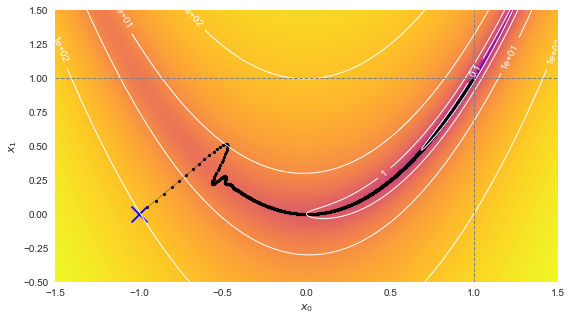

In [20]:
plot_rosenbrock(path=path);

### Probabilistic Programming: Edward

In [21]:
import edward as ed
import edward.models

In [22]:
print(edward.__version__)

1.3.5


#### Example: minimize KL divergence

Define a Normal distribution $p(\theta)$:

In [23]:
p = ed.models.Normal(loc=0., scale=1.)

Define a variational family of Laplace distributions $q(\theta; s)$ explored by the scale parameter $s$:

In [24]:
s = tf.Variable(1.)
q = ed.models.Laplace(loc=0., scale=s)

Find the "closest" $q(\theta; s)$ to $p(\theta)$ using variational inference (VI):

In [25]:
inference = ed.KLqp({p: q})
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: -0.284


Compare with the [exact result](Variational.ipynb) $2^{-1/2}$:

In [26]:
print('s(approx) = {:.3f} , s(exact) = {:.3f}'.format(s.eval(), 1 / np.sqrt(2)))

s(approx) = 0.853 , s(exact) = 0.707


The result is not exact since Edward implements "black box" VI, where the integrals are estimated with importance sampled Monte Carlo. However, we can get closer to the exact result with more computation:

In [27]:
s_opt = []
for _ in range(10):
    inference.run(n_iter=5000)
    s_opt.append(s.eval())

5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -0.281
5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -0.183
5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 0.387
5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 0.498
5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -0.055
5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 0.013
5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 0.521
5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 0.131
5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -0.417
5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 0.281


s = 0.710 +/- 0.013


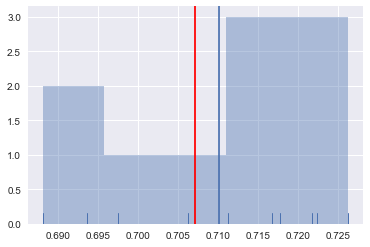

In [28]:
sns.distplot(s_opt, rug=True, kde=False, bins=5)
plt.axvline(np.mean(s_opt))
plt.axvline(1 / np.sqrt(2), c='r')
print('s = {:.3f} +/- {:.3f}'.format(np.mean(s_opt), np.std(s_opt)))

The example above uses a default tensor flow graph and session, which generates a different answer each time and consumes memory each time it is run.  For more control, manage the graph and session yourself and set the random seed:

In [29]:
graph = tf.Graph()
with graph.as_default():
    p = ed.models.Normal(loc=0., scale=1.)
    s = tf.Variable(1.)
    q = ed.models.Laplace(loc=0., scale=s)

In [30]:
with tf.Session(graph=graph) as session:
    tf.set_random_seed(123)
    inference = ed.ScoreKLqp({p: q})
    inference.run(n_iter=10000)
    # Evaluate p(theta) and the optimized q(theta) on a grid of theta values.
    theta_grid = np.linspace(-5, +5, 101, dtype=np.float32)
    p_grid, q_grid, s_opt = session.run([p.prob(theta_grid), q.prob(theta_grid), s])

10000/10000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -0.174


s(approx) = 0.706 , s(exact) = 0.707


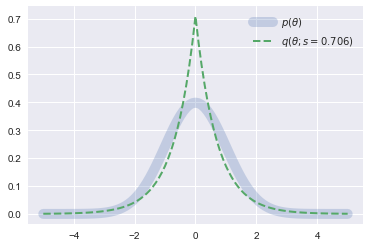

In [31]:
plt.plot(theta_grid, p_grid, lw=10, alpha=0.25, label='$p(\\theta)$')
label = '$q(\\theta;s={:.3f})$'.format(s_opt)
plt.plot(theta_grid, q_grid, '--', lw=2, label=label)
plt.legend()
print('s(approx) = {:.3f} , s(exact) = {:.3f}'.format(s_opt, 1 / np.sqrt(2)))

#### Example: variational Bayesian inference

To perform Bayesian inference of a posterior, we first build a model that explains the observed random variables ($D$) in terms of the un-observed random variables ($\Theta$). For example, suppose the data $D$ consists of 200 values $x_i$ drawn from the same normal distribution with true parameters $\mu=0$, $\sigma=1$ (this is the same dataset we used [earlier](Optimization.ipynb)):

In [32]:
import scipy.stats

In [33]:
D = scipy.stats.norm.rvs(loc=0, scale=1, size=200, random_state=123)

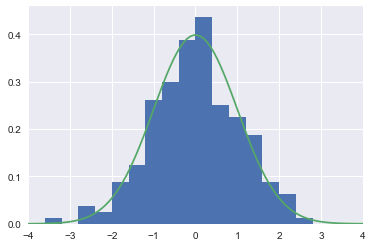

In [34]:
x = np.linspace(-4, +4, 100)
plt.hist(D, range=(x[0], x[-1]), bins=20, normed=True)
plt.plot(x, scipy.stats.norm.pdf(x,loc=0,scale=1))
plt.xlim(x[0], x[-1]);

The (unobserved) random variables $\mu$ and $\sigma$ are drawn from their prior distributions, which we take to be uniform in $\mu$ and $t = \log\sigma$ (the same "natural" priors we used [earlier](Optimization.ipynb)), with $-1 \le \mu \le +1$ and $0.5 \le \sigma \le 1.5$:

In [35]:
graph = tf.Graph()
with graph.as_default():
    mu = ed.models.Uniform(-1., +1.)
    t = ed.models.Uniform(tf.log(0.5), tf.log(1.5))

We can now generate (reproducible) samples from the prior (note that the seeds must be different to generate independent values of $\mu$ and $s$):

In [36]:
n_samples = 500
with tf.Session(graph=graph) as session:
    mu_samples, t_samples = session.run([mu.sample(n_samples, seed=1), t.sample(n_samples, seed=2)])

Transform $s$ back to $\sigma$ and plot these samples:

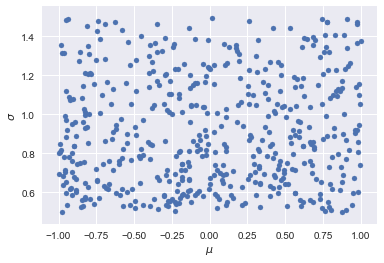

In [37]:
sigma_samples = np.exp(t_samples)
plt.scatter(mu_samples, sigma_samples, s=25)
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$');

The 200 (observed) random variables $x_i$ are drawn from the same normal distribution (note the use of `tf.exp` to convert $s$ back to $\sigma$):

In [38]:
with graph.as_default():
    X = ed.models.Normal(loc=tf.fill(D.shape, mu), scale=tf.fill(D.shape, tf.exp(t)))

Each sample from $X$ is now 200 values $x_i$ generated with the same $(\mu, t)$ drawn from the prior. Different calls to `X.sample` use different values of $(\mu, t)$ drawn from the prior (note that samples are no longer reproducible, which I consider a bug):

In [39]:
n_samples = 3
with tf.Session(graph=graph) as session:
    X_samples1 = session.run(X.sample(n_samples, seed=1))
    X_samples2 = session.run(X.sample(n_samples, seed=2))

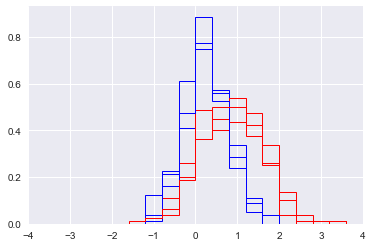

In [40]:
for i in range(n_samples):
    plt.hist(X_samples1[i], range=(-4, 4), bins=20, normed=True, histtype='step', color='b', lw=1)
    plt.hist(X_samples2[i], range=(-4, 4), bins=20, normed=True, histtype='step', color='r', lw=1)
plt.xlim(-4, 4);

Our goal is to infer the true posterior,
$$
P(\mu, \sigma\mid D) = P(\mu,\sigma)\, \prod_i\, P(x_i\mid \mu,\sigma) \; ,
$$
so we define an approximating family explored by $\mathbf{s} = (s_1, s_2, s_3)$,
$$
q(\mu, \sigma; \mathbf{s}) = G(\mu; 0, e^{s_1})\, G(t; s_2, e^{s_3}) \; ,
$$
where $G$ is a normalized Gaussian distribution. Note that we use $e^{s_1}$ and $e^{s_3}$ to map from unconstrained parameters to the Gaussian scales, to ensure they are positive.  There is nothing special about this choice since any $\mathbf{s}$ that explores the full allowed range of the variational family is valid (although it might be easier or harder to optimize over). In deep learning applications, a more popular alternative to ensure a positive quantity is the [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [41]:
with graph.as_default():
    # Define the G(mu) factor of q.
    s1 = tf.Variable(tf.log(0.06))
    q_mu = ed.models.Normal(loc=0., scale=tf.exp(s1))
    # Define the G(t) factor of q.
    s2 = tf.Variable(tf.log(1.0))
    s3 = tf.Variable(tf.log(1.05))
    q_t = ed.models.Normal(loc=s2, scale=tf.exp(s3))

Finally, find the "closest" $q$ to the posterior by minimizing the KL divergence with respect to $\mathbf{s} = (s_1, s_2, s_3)$:

In [42]:
with tf.Session(graph=graph) as session:
    tf.set_random_seed(123)
    inference = ed.KLqp({mu: q_mu, t: q_t}, data={X: D})
    inference.run(n_iter=5000)
    s1_opt, s2_opt, s3_opt = session.run([s1, s2, s3])

5000/5000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: 298.498


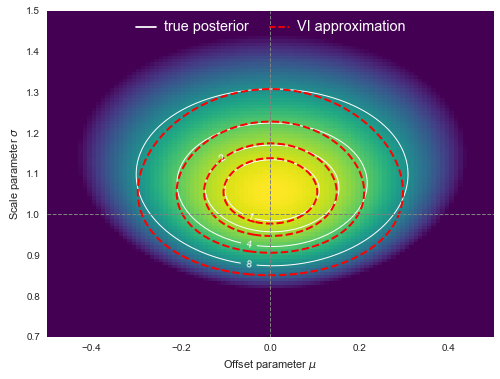

In [43]:
plot_posterior(D, VI=(0., s1_opt, s2_opt, s3_opt))

Note how the VI contours (dashed red) do not exactly follow the true contours (white) but still capture the shape of the true posterior reasonably well.

#### Example: Hamiltonian Markov-chain Monte Carlo for Bayesian inference

For our final example, we will re-use the model above but use HMC instead of VI for inference.

In [44]:
n_mc = 1000
with graph.as_default():
    mc_mu = ed.models.Empirical(params=tf.Variable(tf.zeros(n_mc)))
    mc_t = ed.models.Empirical(params=tf.Variable(tf.ones(n_mc)))

In [45]:
with tf.Session(graph=graph) as session:
    tf.set_random_seed(123)
    inference = ed.HMC({mu: mc_mu, t: mc_t}, data={X: D})
    inference.run(step_size=0.01, n_steps=10)
    mu_samples, t_samples = session.run([mc_mu.params, mc_t.params])

1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Acceptance Rate: 0.995


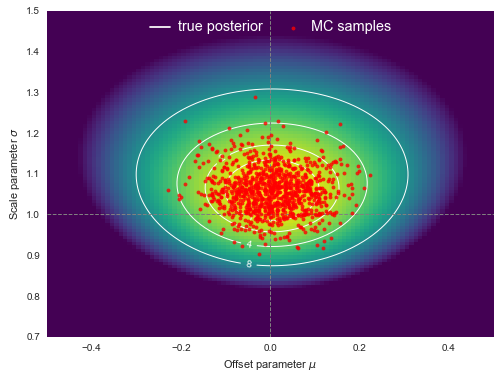

In [46]:
plot_posterior(D, MC=(mu_samples, np.exp(t_samples)))